# 12 空间变换

## 齐次坐标系

在三维空间中, 齐次坐标系 (homogeneous coordinate) 用四个数 $(x,y,z,w)$ 表示一个三维坐标。点
$$(x,y,z,w)\mapsto \left(\frac xw,\frac yw,\frac zw\right)$$

将 $(x,y,z,w)$ 同时乘上一个(非零的)倍数不改变表示的点. 所以是齐次的. 例如 $(x,y,z,1)$ 对应的三维坐标就是 $(x,y,z)$.

### 平移

将一个点的位置平移, 可以看成齐次坐标被一个矩阵乘:
$$\left[\begin{matrix}x+\Delta x \\ y + \Delta y \\ z + \Delta z\\ 1\end{matrix}\right] = 
\left[\begin{matrix}1 & 0 & 0 & \Delta x \\ 0 & 1 & 0 & \Delta y\\ 0 & 0 & 1& \Delta z\\ 0 & 0 & 0 &  1\end{matrix}\right] 
\left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right] 
$$

### 旋转

三维坐标 $(x,y,z)$ 通过正交矩阵 $Q$ 旋转等价于齐次坐标被一个正交矩阵乘:
$$\left[\begin{matrix}x'\\ y'\\ z' \\ 1\end{matrix}\right] = 
\left[\begin{matrix}  &   &   &  \\   & Q &   &  0\\   &   &  & \\  & 0 &  &  1\end{matrix}\right] 
\left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right] 
$$

### 拉伸变换

$$\left[\begin{matrix}x'\\ y'\\ z' \\ 1\end{matrix}\right] = 
\left[\begin{matrix}  s_1 &   &   &  \\   & s_2 &   &  \\   &   & s_3  & \\  &  &  &  1\end{matrix}\right] 
\left[\begin{matrix}x \\ y \\ z \\ 1\end{matrix}\right] 
$$

<br>

注: 若在二维空间中, 则对应的齐次坐标就是三维的.

## 局部仿射

### 点云

点云 (point cloud) 是一种记录三维空间物体的方法. 即记录三维空间中所有实体点的坐标和像素值.

### 局部仿射 

对于一个空间, 先取定 $n$ 个点 $v_1,\dotsc,v_n$ 和 $n$ 个仿射变换矩阵 $A_1,\dotsc,A_n$, 以及参数 $\alpha>0$. 则对于空间中任何一点 $x$, 定义如下映射 (一些仿射变换的加权平均):
$$w_i = \frac{\Vert x - v_i\Vert^{-\alpha}}{ \sum_{j=1}^n\Vert x - v_j\Vert^{-\alpha}}\quad{\rm and}\quad f(x) = \sum_{i=1}^n w_iA_ix$$

每个点都会映射到新的位置 $f(x)$. 

由于 $x$ 离某个控制点 $v_i$ 越近, 则 $A_i$ 前面的系数 $w_i$ 越大, 所以这被称为局部仿射变换. (locally affine transformation)

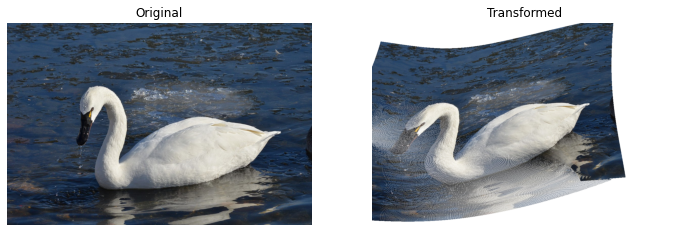

In [33]:
import numpy as np
def locally_affine_transform(img, points, affines, alpha = 1.):
    """Locally affine transformation applied on 2D images."""
    h, w, d = img.shape[0], img.shape[1], img.size // (img.shape[0] * img.shape[1])

    # 1. compute weights of affine mappings
    coors = np.stack(np.meshgrid(np.arange(w), np.arange(h)))
    coors = np.transpose(coors, (1, 2, 0)).reshape((-1, 2))                      # shape: (hw) x 2
    coors_ =  np.tile(coors.reshape((-1, 1, 2)), (1, points.shape[0], 1))        # shape: (hw) x n x 2
    weights = np.linalg.norm(coors_ - points.reshape((1, -1, 2)), axis = -1)     # shape: (hw) x n
    weights = (weights + 1e-8) ** (-alpha)                                       # shape: (hw) x n
    weights /= weights.sum(axis = 1, keepdims = True)                            # shape: (hw) x n

    # 2. construct homogeneous coordinates
    coors = np.hstack((coors, np.ones((h * w, 1))))                         # shape: (hw) x 3
    coors = np.transpose(np.matmul(affines, coors.T), (2, 0, 1))            # shape: (hw) x n x 3
    coors = (np.expand_dims(weights, axis = -1) * coors).sum(axis = 1)      # shape: (hw) x 3

    # 3. extract the pixels inside the canva
    coors = coors[:,:-1] / coors[:,-1:]
    valid_coors = (coors[:,0] > 0) & (coors[:,0] < w - 1) & (coors[:,1] > 0) & (coors[:,1] < h - 1)
    valid_coors = valid_coors.reshape((-1, 1))
    coors = np.extract(np.tile(valid_coors, (1, 2)), coors).reshape((-1, 2)).astype('int32')
    img_  = np.extract(np.tile(valid_coors, (1, d)), img.reshape((h*w, -1))).reshape((-1, d))
    
    # 4. map pixels to the new image
    coors = (coors[:,1] * w + coors[:,0]) # coordinates to 1d indices
    new_img = np.full_like(img, 255).reshape((h*w, -1))
    new_img[np.ix_(coors)] = img_ # fill pixels

    return new_img.reshape(img.shape)


import os
from matplotlib import pyplot as plt
from PIL import Image

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\swan.png')))

points = np.array([[600,800],[200,400],[500,300]])
affines = np.array([[[.8,.6,0],[-.6,1.2,20],[0,0,1]],
                    [[.8,-.6,0],[.6,.8,0],[0,0,1]],
                    [[.7,-.2,100],[-.2,.7,200],[0,0,1]]])

new_img = locally_affine_transform(img, points,affines)

plt.figure(figsize = (12, 5))
for i, image, title in zip(range(2), (img, new_img), ('Original', 'Transformed')):
    plt.subplot(1, 2, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
plt.show()

## 自由形变

[图像自由形变](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=796284&tag=1) (free-form deformation, FFD): 对于一个三维空间的图像, 假设有若干个点 $\Omega = \{(x_i,y_i,z_i)|\ i=1,\dotsc,n\}$


### B 样条

给定四个点 $y_i\ (i=1,2,3,4)$, 定义对应的三次 [均匀 B 样条 (uniform B-spline)](https://mathworld.wolfram.com/B-Spline.html) 为:

$$f(x) = \frac{(1-x)^3}{6}y_1+\frac{3x^3-6x^2+4}{6}y_2+\frac{-3x^3+3x^2+3x+1}{6}y_3+\frac{x^3}{6}y_4
$$

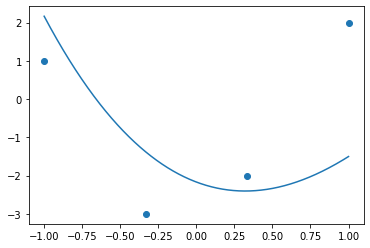

In [1]:
import numpy as np
from matplotlib import pyplot as plt
y = [1,-3,-2,2]
l, r = -1, 1
x = np.linspace(l, r, 1000)
f = ((1-x)**3*y[0] + (3*x**3-6*x*x+4)*y[1] + ((x*x+x-x**3)*3+1)*y[2] + x**3*y[3])/6
plt.plot(x, f)
plt.scatter(np.linspace(l, r, 4), y)
plt.show()